In [1]:
%matplotlib inline

from matplotlib import rc
from fourierPSF.fourierModel import *
from mavis import *

rc("text", usetex=False)

In [2]:
path = "/home/frossi/dev/MASTSEL/"
parametersFile = 'mavisParams'
fullPathFilename = path + parametersFile + '.ini'
windPsdFile = 'data/windpsd_mavis.fits'

parser = ConfigParser()
parser.read(fullPathFilename);
wvl = eval(parser.get('PSF_DIRECTIONS', 'ScienceWavelength'))[0]  # lambda
tel_radius = eval(parser.get('PSF_DIRECTIONS', 'psInMas'))/2
pixel_psf = eval(parser.get('telescope', 'TelescopeDiameter'))      # mas
polarNGSCoordsList = [[30.0,0.0], [50.0,100.0],[10.0,240.0]]
polarNGSCoords = np.asarray(polarNGSCoordsList)

gridElements = 1
xxPointigs, yyPointigs = np.linspace(-15, 15, gridElements), np.linspace(-15,15, gridElements)

In [3]:
fao = fourierModel(fullPathFilename, calcPSF=True, verbose=False, display=False, extraPSFsDirections=polarNGSCoordsList)
PSD = fao.powerSpectrumDensity()
PSD = PSD.transpose()
N = PSD[0].shape[0]

In [4]:
print(fao.zenithSrc)

[ 0. 30. 50. 10.]


446
scaleFactor: 9.638285547938826e-05
dk: 56116722.78338946


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


[0.05990988355947293, 0.0005348733542717612, 0.4352715080419849]
[16.509523065548745, 32.485260178451895, 16.024439542036273]


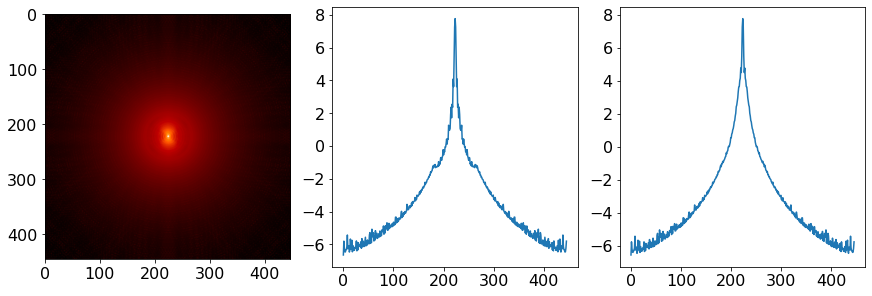

In [5]:
freq_range = fao.fovInPixel*fao.PSDstep # fao.psf_FoV/fao.wvlRef/206264.8
pitch = 1/freq_range
grid_diameter = pitch*N

scaleFactor = (2*np.pi*1e-9/wvl)**2
dk = 2*fao.kc/fao.resAO * 1e9

print(N)
print('scaleFactor:', scaleFactor)
print('dk:', dk)

def psdSetToPsfSet(inputPSDs):
    NGS_SR_1650 = []
    psdArray = []
    psfLongExpArr = []
    NGS_FWHM_mas = []
    mask = Field(wvl, N, pitch*N)
    sx = int(TelescopeDiameter/pitch)
    mask.sampling = cp.asarray(congrid(fao.tel.pupil, [sx, sx]))
    mask.sampling = zeroPad(mask.sampling, (N-sx)//2)
    for computedPSD in inputPSDs:    
        psd = Field(wvl, N, freq_range, 'rad')
        psd.sampling = cp.asarray(computedPSD / dk**2 )
        scaledSampling = computedPSD * scaleFactor
        sr = np.exp(-scaledSampling.sum())
        psfLongExp = longExposurePsf(mask, psd )
        fw = (psfLongExp.FWHM()[0] + psfLongExp.FWHM()[1])/2 * 180 / np.pi * 3600 * 1000 
        NGS_SR_1650.append(sr)
        psdArray.append(psd)
        psfLongExpArr.append(psfLongExp)
        NGS_FWHM_mas.append(fw)
        
    return NGS_SR_1650, psdArray, psfLongExpArr, NGS_FWHM_mas

NGS_SR_1650, psdArray, psfLongExpArr, NGS_FWHM_mas = psdSetToPsfSet(PSD[-3:])

print(NGS_SR_1650)
print(NGS_FWHM_mas)
psfLongExpArr[0].standardPlot(True)
# psfLongExp.printStatus()

In [6]:
NGS_flux = [10000, 30000, 5000]
# old values: NGS_SR_1650 = [0.4, 0.2, 0.6]
# old values: NGS_FWHM_mas = [90, 110, 85]

In [7]:
cartPointingCoords =  np.dstack(np.meshgrid(xxPointigs, yyPointigs)).reshape(-1, 2)
cartNGSCoords = np.asarray([polarToCartesian(polarNGSCoords[0,:]), polarToCartesian(polarNGSCoords[1,:]), polarToCartesian(polarNGSCoords[2,:])])
mLO = MavisLO(path, parametersFile, windPsdFile)
Ctot = mLO.computeTotalResidualMatrix(np.array(cartPointingCoords), cartNGSCoords, NGS_flux, NGS_SR_1650, NGS_FWHM_mas)
cov_ellipses = mLO.ellipsesFromCovMats(Ctot)

In [8]:
pointings_SR_1650, psdPointingsArray, psfLongExpPointingsArr, pointings_FWHM_mas = psdSetToPsfSet(PSD[:-3])

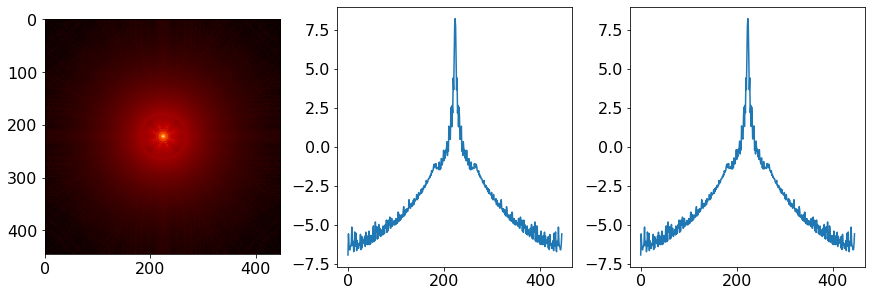

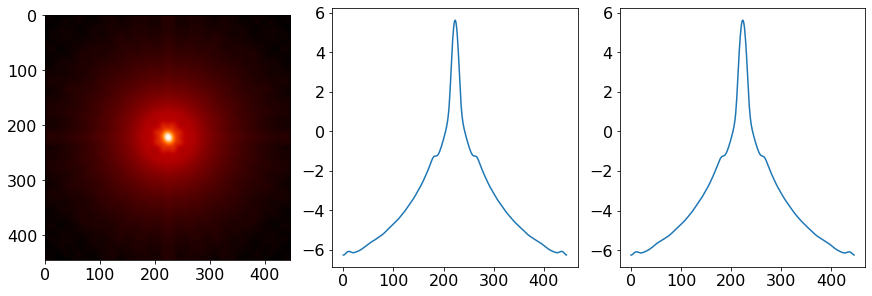

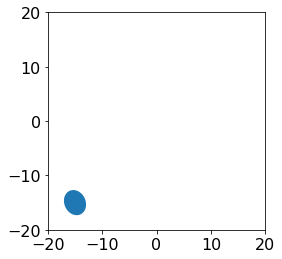

TypeError: 'AxesSubplot' object is not subscriptable

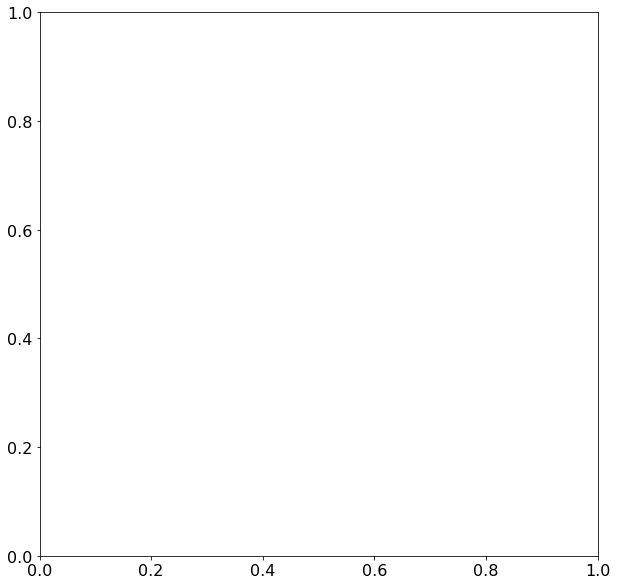

In [9]:
results = []
for ellp, psfLongExp in zip(cov_ellipses, psfLongExpPointingsArr):
    results.append(convolve(psfLongExp, residualToSpectrum(ellp, N, fao.psf_FoV)))

psfLongExpPointingsArr[0].standardPlot(True)
results[0].standardPlot(True)

plotEllipses(cartPointingCoords, cov_ellipses, 0.014)
tiledDispaly(results)

In [ ]:
#hdul1 = fits.HDUList()
#hdul1.append(fits.PrimaryHDU())
#hdul1.append(fits.ImageHDU(data=fao.PSF[0]))
#hdul1.writeto('psfOlivier.fits')